# Segmenting Cells in Python

### Goal
The goal of the project was to write a program for automated segmentation of cells in fluorescent images. We also hoped to perform co-localization analysis such that if you segmented two channels of an image you could then get the % colocalization of cells in the two channels.

### Accomplished so far:
So far, we have written functions to open tif files, show multi-planed images, blur 3d images w/ 3 methods, equalize histograms for 3d images w/ 4 methods, perform blob detection on 3d images w/ 3 methods, perform clustering on cell positions, and a few convenience plotting functions. We did not get to performing co-localization analysis since, unfortunately, even combining most of these methods does not produce fully accurate cell counting - but it's a start!

### Future Directions:
There are several possibilities for the direction this project could take. First, we need to optimize the parameters for all of these functions to produce the best result possible. We may also add other filtering and clustering methods. Another feature we would like to add is user defined ROIs so that you could load a large image and only segment the part you're interested in.

Given how difficult this task is (*fully* automated cell counting), we could also look into wrapping this program into a *semi*-automated cell counting program that allows an experimenter to run this program to get a semi-segmented image, then manually edit the segmentation (add and delete cell markers). Although this is not ideal, it would greatly speed the process of counting cells. 

## Imports

In [2]:
# Import required packages
import skimage as sk

from skimage import io
from skimage import exposure
from skimage import io
from skimage import feature
from skimage import filters
from skimage import morphology
from skimage.filters import rank
from skimage.morphology import disk
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

## Functions for selecting an image file and saving a dataframe to a CSV

In [3]:
# prompt for image

def get_image():
    img_file = input('Enter full file path: ')
    img_raw = sk.io.imread(img_file)
    return img_raw

def save_to_file(dataframe):
    file_name = input('Enter a file path to save to (do not include .csv):')
    file_name = file_name + ".csv"
    dataframe.to_csv(file_name)

## Visualization

In [4]:
# Function to show images. 
# Takes image file, number of planes of the image to be shown, and a tuple/list containing the desired shape 
# of the axes array (optional)

def show_image(image, nplanes, subplot_shape = None):
    if subplot_shape == None:
        for i in range(nplanes):
            plt.figure()
            plt.imshow(image[i,:,:], cmap = 'gray')
            plt.axis('off')
    else:
        f, ax = plt.subplots(subplot_shape[0], subplot_shape[1], figsize = (20,20))
        ax = ax.ravel()
        for i in range(nplanes):
            ax[i].imshow(img_raw[i,:,:], cmap = 'gray')
            ax[i].axis('off')
            ax_title = str(i+1)
            ax[i].set_title(ax_title)
            
def img_hist_single(image):

    f, ax = plt.subplots(ncols=2, figsize=(20,10));
    ax[0].hist(image.ravel(), bins=256)
    ax[1].imshow(image, cmap='gray')
    
def img_hist_stack(image, stack):

    f, ax = plt.subplots(ncols=2, figsize=(20,10));
    ax[0].hist(image[stack,:, :].ravel(), bins=256)
    ax[1].imshow(image[stack,:, :], cmap='gray') 
    
# convenience function for plotting detected blobs
def plot_blobs(blobs, color, size_mod, fill = True):
    for blob in blobs:
        y, x, size, z = blob
        c = plt.Circle((x, y), size*size_mod, color=color, linewidth=2, fill=fill)
        ax.add_patch(c)
        
def plot_cells_inplane(image, cells):
    """Convenience function for plotting the cells found in each plane on an image of that plane. 
    Takes image and cells. Cells must be pandas data frame with columns x, y, and z. Z must contain integers only."""
    for i in range(len(image)):
        dat = cells[cells['z'] == i]
        plt.figure()
        plt.imshow(image[i, :,:])
        plt.scatter(dat['x'], dat['y'], c='r')

## Filtering/Smoothing/Blurring

In [5]:
# Blurring Functions

# Mean blur. Increased disk_size = more smoothing
def mean_blur(image, disk_size):
    
    """skimage.filters.rank.mean documentation:
    Return local mean of an image.

    Parameters
    ----------
    image : 2-D array (uint8, uint16)
        Input image.
    selem : 2-D array
        The neighborhood expressed as a 2-D array of 1's and 0's.
    out : 2-D array (same dtype as input)
        If None, a new array is allocated.
    mask : ndarray
        Mask array that defines (>0) area of the image included in the local
        neighborhood. If None, the complete image is used (default).
    shift_x, shift_y : int
        Offset added to the structuring element center point. Shift is bounded
        to the structuring element sizes (center must be inside the given
        structuring element).

    Returns
    -------
    out : 2-D array (same dtype as input image)
        Output image.
    """
    img_meanfilt = np.empty_like(image)
    for i in range(len(image)):
        img_meanfilt[i,:,:] = filters.rank.mean(image[i,:,:], disk(disk_size))
    return img_meanfilt

# Median blur. Increased disk_size = more smoothing
def median_blur(image, disk_size):
    """skimage.filters.rank.median documentation:
    Return local median of an image.

    Parameters
    ----------
    image : 2-D array (uint8, uint16)
        Input image.
    selem : 2-D array, optional
        The neighborhood expressed as a 2-D array of 1's and 0's. If None, a
        full square of size 3 is used.
    out : 2-D array (same dtype as input)
        If None, a new array is allocated.
    mask : ndarray
        Mask array that defines (>0) area of the image included in the local
        neighborhood. If None, the complete image is used (default).
    shift_x, shift_y : int
        Offset added to the structuring element center point. Shift is bounded
        to the structuring element sizes (center must be inside the given
        structuring element).

    Returns
    -------
    out : 2-D array (same dtype as input image)
        Output image.
    """
    img_medianfilt = np.empty_like(image)
    for i in range(len(image)):
        img_medianfilt[i,:,:] = filters.rank.median(image[i,:,:], disk(disk_size))
    return img_medianfilt

# Gaussian blur. Increased sigma = more smoothing
def gaussian_blur(image, sigma):
    """skimage.filters.gaussian documentation:
    Multi-dimensional Gaussian filter.

    Parameters
    ----------
    image : array-like
        Input image (grayscale or color) to filter.
    sigma : scalar or sequence of scalars, optional
        Standard deviation for Gaussian kernel. The standard
        deviations of the Gaussian filter are given for each axis as a
        sequence, or as a single number, in which case it is equal for
        all axes.
    output : array, optional
        The ``output`` parameter passes an array in which to store the
        filter output.
    mode : {'reflect', 'constant', 'nearest', 'mirror', 'wrap'}, optional
        The `mode` parameter determines how the array borders are
        handled, where `cval` is the value when mode is equal to
        'constant'. Default is 'nearest'.
    cval : scalar, optional
        Value to fill past edges of input if `mode` is 'constant'. Default
        is 0.0
    multichannel : bool, optional (default: None)
        Whether the last axis of the image is to be interpreted as multiple
        channels. If True, each channel is filtered separately (channels are
        not mixed together). Only 3 channels are supported. If `None`,
        the function will attempt to guess this, and raise a warning if
        ambiguous, when the array has shape (M, N, 3).
    preserve_range : bool, optional
        Whether to keep the original range of values. Otherwise, the input
        image is converted according to the conventions of `img_as_float`.
    truncate : float, optional
        Truncate the filter at this many standard deviations.

    Returns
    -------
    filtered_image : ndarray
        the filtered array

    Notes
    -----
    This function is a wrapper around :func:`scipy.ndi.gaussian_filter`.

    Integer arrays are converted to float.

    The multi-dimensional filter is implemented as a sequence of
    one-dimensional convolution filters. The intermediate arrays are
    stored in the same data type as the output. Therefore, for output
    types with a limited precision, the results may be imprecise
    because intermediate results may be stored with insufficient
    precision.
    """
    # must convert image to float for this to work in a loop (unknown reason)
    image = (image*1.0)/np.max(image)
    img_gaussian = np.empty_like(image)
    for i in range(len(image)):
        img_gaussian[i,:,:] = filters.gaussian(image[i,:,:], sigma)
    return img_gaussian


## Histogram Equalization

In [6]:
# Histogram Equalization
# Local histogram equalization
def local_eq(img, selem=disk(5000), **kwargs):
    """
    Equalize image using local (user-defined) histogram

    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    mage : 2-D array (uint8, uint16)
        Input image.
    
    selem : 2-D array
        The neighborhood expressed as a 2-D array of 1's and 0's.
    
    out : 2-D array (same dtype as input)
        If None, a new array is allocated.
    
    mask : ndarray
        Mask array that defines (>0) area of the image included in the local
        neighborhood. If None, the complete image is used (default).
    
    shift_x, shift_y : int
        Offset added to the structuring element center point. Shift is bounded
        to the structuring element sizes (center must be inside the given
        structuring element).  
                
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        output image
    
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    [2]: http://en.wikipedia.org/wiki/Histogram_equalization


    """
    

    img_local_eq = np.empty_like(img)
    for z in range(len(img)):
        img_local_eq[z, :, :] = rank.equalize(img[z, :, :], selem)

    return img_local_eq

# Contrast stretching

def contrast_stretch(img, p1=2, p2=98, **kwargs):
    """
    intensity-based contrast stretching/shrinking. 
    returns a z-stack with each plane stretched/shrunk.

    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    image: (M, N[,C]) ndarray
        input image
        
    in_range, out_range: str or 2-tuple
        Min and max intesnity values of input and output image. 
        The possible values for this parameter are enumerated below.
    
        'image': use image min/max as the intensity range
        
        'dtype': use min/max of the images dtype as the intensity range
        
        'dtype-name': use intensity range absed on desired dtype. Must be valid key in DTYPE_RANGE
        
        '2-tuple': Use range_values as explicit min/max intensities
            
                
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        equalized image
    
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    [2]: http://en.wikipedia.org/wiki/Histogram_equalization


    """
    
    pct1, pct2 = np.percentile(img, (p1, p2))
    
    img_cs = np.empty_like(img)
    for z in range(len(img)):
        img_cs[z, :, :] = exposure.rescale_intensity(img[z, :, :], in_range=(pct1, pct2), **kwargs)
    return img_cs

# Global histogram equalization
def heq(img, **kwargs):
    """
    takes an image containing z-stacks and applies a histogram equalization algorithm 
    to each plane of the stack and returns the equalized z-stack
    
    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    image: (M, N[,C]) ndarray
        input image
        
    nbins: int, optional
        Number of gray bins for histogram ('data range')
     
     mask: ndarray of bools or 0s and 1s, optional
         Array of same shape as image. Only points at which mask==True are uesd for the equalization, 
         which is applied to the whole image.
    
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        equalized image
    
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_hist
    [2]: http://en.wikipedia.org/wiki/Histogram_equalization

    """
       
    img_heq = np.empty_like(img)
    for z in range(len(img)):
        img_heq[z, :, :] = exposure.equalize_hist(img[z, :, :], **kwargs)
    return img_heq


# Adaptive histogram equalization

def adapt_eq(img, clip_limit=0.03, **kwargs):
    """
    takes an image containing z-stacks and applies an adaptive histogram equalization algorithm 
    to each plane of the stack and returns the equalized z-stack
    
    Utilizes CLHAE: Contrast Limited Adaptive Histogram Equalization.

    An algorithm for local contrast enhancement, that uses histograms computed over different tile regions of the image. 
    Local details can therefore be enhanced even in regions that are darker or lighter than most of the image.
    
    ------------
    Parameters:
    ------------
    image: (M, N[,C]) ndarray
        input image
    
    kernel_size: integer or list-like, optional
        Defines the shape of contextual regions used in the algorithm. 
        If iterable is passed, it must have the same number of elements as image.ndim (without color channel). 
        If integer, it is broadcasted to each image dimension. 
        By default, kernel_size is 1/8 of image height by 1/8 of its width.
    
    clip_limit: float_optional
        Clipping limit, normalized between 0 and 1 (higher values give more contrast)
        
    nbins: int, optional
        Number of gray bins for histogram ('data range')
        
    
    ------------  
    Returns:
    ------------  
    out: (M, N[,C]) ndarray
        equalized image
    
    
    ------------
    See also:
    ------------
    equalize_hist, rescale_intensity
    
    ------------
    Notes:
    ------------
    - For color images, the following steps are performed:
        - The image is converted to HSV color space
        - The CLAHE algorithm is run on the V (Value) channel
        - The image is converted back to RGB space and returned
    
    ------------
    References:
    ------------
    [1]: http://scikit-image.org/docs/dev/api/skimage.exposure.html#skimage.exposure.equalize_adapthist
    [2]: http://tog.acm.org/resources/GraphicsGems/
    [3]: https://en.wikipedia.org/wiki/CLAHE#CLAHE

    """
       
    img_adeq = np.empty_like(img)
    for z in range(len(img)):
        img_adeq[z, :, :] = exposure.equalize_adapthist(img[z, :, :], **kwargs)
    return img_adeq


## Segmentation

In [7]:
# 3D Blob Detection Functions
# takes image, min_sigma (affects minimum cell size found), max_sigma (affects max cell size found),
# threshold (affects how bright cells must be to be detected)

# These do NOT perform blob detection in 3D. Rather, they perform 2D blob detection across all planes of the image
# and return an array of y, x, size, z

# Laplacian of Gaussian
def detect_blobs_3dlog(image, min_sigma=10, max_sigma=20, threshold=.003): 
    """skimage.feature.blob_log documentation:
    Finds blobs in the given grayscale image.

    Blobs are found using the Laplacian of Gaussian (LoG) method [1]_.
    For each blob found, the method returns its coordinates and the standard
    deviation of the Gaussian kernel that detected the blob.

    Parameters
    ----------
    image : ndarray
        Input grayscale image, blobs are assumed to be light on dark
        background (white on black).
    min_sigma : float, optional
        The minimum standard deviation for Gaussian Kernel. Keep this low to
        detect smaller blobs.
    max_sigma : float, optional
        The maximum standard deviation for Gaussian Kernel. Keep this high to
        detect larger blobs.
    num_sigma : int, optional
        The number of intermediate values of standard deviations to consider
        between `min_sigma` and `max_sigma`.
    threshold : float, optional.
        The absolute lower bound for scale space maxima. Local maxima smaller
        than thresh are ignored. Reduce this to detect blobs with less
        intensities.
    overlap : float, optional
        A value between 0 and 1. If the area of two blobs overlaps by a
        fraction greater than `threshold`, the smaller blob is eliminated.
    log_scale : bool, optional
        If set intermediate values of standard deviations are interpolated
        using a logarithmic scale to the base `10`. If not, linear
        interpolation is used.

    Returns
    -------
    A : (n, 3) ndarray
        A 2d array with each row representing 3 values, ``(y,x,sigma)``
        where ``(y,x)`` are coordinates of the blob and ``sigma`` is the
        standard deviation of the Gaussian kernel which detected the blob.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Blob_detection#The_Laplacian_of_Gaussian
    """
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            log_cells = sk.feature.blob_log(image[0,:,:], min_sigma = min_sigma, max_sigma = max_sigma, 
                                            threshold = threshold)
            log_cells = np.column_stack((log_cells, np.zeros((len(log_cells)))))
        else:
            new_cells = sk.feature.blob_log(image[i,:,:], min_sigma = min_sigma, max_sigma = max_sigma, 
                                            threshold = threshold)
            new_cells = np.column_stack((new_cells, np.full((len(new_cells)), i)))
            log_cells = np.concatenate((log_cells, new_cells))
    return log_cells

# Determinant of Hessian
def detect_blobs_3dhess(image, min_sigma=10, max_sigma=20, threshold=.00008):
    
    """skimage.feature.blob_doh documentation:
    Finds blobs in the given grayscale image.

    Blobs are found using the Determinant of Hessian method [1]_. For each blob
    found, the method returns its coordinates and the standard deviation
    of the Gaussian Kernel used for the Hessian matrix whose determinant
    detected the blob. Determinant of Hessians is approximated using [2]_.

    Parameters
    ----------
    image : ndarray
        Input grayscale image.Blobs can either be light on dark or vice versa.
    min_sigma : float, optional
        The minimum standard deviation for Gaussian Kernel used to compute
        Hessian matrix. Keep this low to detect smaller blobs.
    max_sigma : float, optional
        The maximum standard deviation for Gaussian Kernel used to compute
        Hessian matrix. Keep this high to detect larger blobs.
    num_sigma : int, optional
        The number of intermediate values of standard deviations to consider
        between `min_sigma` and `max_sigma`.
    threshold : float, optional.
        The absolute lower bound for scale space maxima. Local maxima smaller
        than thresh are ignored. Reduce this to detect less prominent blobs.
    overlap : float, optional
        A value between 0 and 1. If the area of two blobs overlaps by a
        fraction greater than `threshold`, the smaller blob is eliminated.
    log_scale : bool, optional
        If set intermediate values of standard deviations are interpolated
        using a logarithmic scale to the base `10`. If not, linear
        interpolation is used.

    Returns
    -------
    A : (n, 3) ndarray
        A 2d array with each row representing 3 values, ``(y,x,sigma)``
        where ``(y,x)`` are coordinates of the blob and ``sigma`` is the
        standard deviation of the Gaussian kernel of the Hessian Matrix whose
        determinant detected the blob.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Blob_detection#The_determinant_of_the_Hessian

    .. [2] Herbert Bay, Andreas Ess, Tinne Tuytelaars, Luc Van Gool,
           "SURF: Speeded Up Robust Features"
           ftp://ftp.vision.ee.ethz.ch/publications/articles/eth_biwi_00517.pdf
    """
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            hess_cells = sk.feature.blob_doh(image[0,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            hess_cells = np.column_stack((hess_cells, np.zeros((len(hess_cells)))))
        else:
            new_cells = sk.feature.blob_doh(image[i,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            new_cells = np.column_stack((new_cells, np.full((len(new_cells)), i)))
            hess_cells = np.concatenate((hess_cells, new_cells))
    return hess_cells

# Difference of Gaussian
def detect_blobs_3ddog(image, min_sigma=10, max_sigma=20, threshold=.003):
    """skimage.feature.blob_dog documentation:
    Finds blobs in the given grayscale image.

    Blobs are found using the Difference of Gaussian (DoG) method [1]_.
    For each blob found, the method returns its coordinates and the standard
    deviation of the Gaussian kernel that detected the blob.

    Parameters
    ----------
    image : ndarray
        Input grayscale image, blobs are assumed to be light on dark
        background (white on black).
    min_sigma : float, optional
        The minimum standard deviation for Gaussian Kernel. Keep this low to
        detect smaller blobs.
    max_sigma : float, optional
        The maximum standard deviation for Gaussian Kernel. Keep this high to
        detect larger blobs.
    sigma_ratio : float, optional
        The ratio between the standard deviation of Gaussian Kernels used for
        computing the Difference of Gaussians
    threshold : float, optional.
        The absolute lower bound for scale space maxima. Local maxima smaller
        than thresh are ignored. Reduce this to detect blobs with less
        intensities.
    overlap : float, optional
        A value between 0 and 1. If the area of two blobs overlaps by a
        fraction greater than `threshold`, the smaller blob is eliminated.

    Returns
    -------
    A : (n, 3) ndarray
        A 2d array with each row representing 3 values, ``(y,x,sigma)``
        where ``(y,x)`` are coordinates of the blob and ``sigma`` is the
        standard deviation of the Gaussian kernel which detected the blob.

    References
    ----------
    .. [1] http://en.wikipedia.org/wiki/Blob_detection#The_difference_of_Gaussians_approach"""
    
    for i in range(len(image)):
        # the if statement is necessary to create the proper array on the first iteration
        if i == 0:
            dog_cells = sk.feature.blob_dog(image[0,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            dog_cells = np.column_stack((dog_cells, np.zeros((len(dog_cells)))))
        else:
            new_cells = sk.feature.blob_dog(image[i,:,:], min_sigma = min_sigma,
                                                        max_sigma = max_sigma, threshold = threshold)
            new_cells = np.column_stack((new_cells, np.full((len(new_cells)), i)))
            dog_cells = np.concatenate((dog_cells, new_cells))
    return dog_cells



## Clustering

When segmenting across multiple planes or with multiple methods, it's nice to be able to cluster the "cells" found across each plane or with each method to get a single data point per cell rather than many.

In [8]:
# Function for performing unsupervised clustering of centroids to get a single centroid for each cell.
# takes vector of x values, vector of y values,z values, and the maximum distance btwn centroids that form a cluster.

def cluster_centroids(x, y, z, max_dist):
    
    """scipy.cluster.hierarchy documentation:
    Forms flat clusters from the hierarchical clustering defined by
    the given linkage matrix.

    Parameters
    ----------
    Z : ndarray
        The hierarchical clustering encoded with the matrix returned
        by the `linkage` function.
    t : float
        The threshold to apply when forming flat clusters.
    criterion : str, optional
        The criterion to use in forming flat clusters. This can
        be any of the following values:

          ``inconsistent`` : If a cluster node and all its
              descendants have an inconsistent value less than or equal
              to `t` then all its leaf descendants belong to the
              same flat cluster. When no non-singleton cluster meets
              this criterion, every node is assigned to its own
              cluster. (Default)

          ``distance`` : Forms flat clusters so that the original
              observations in each flat cluster have no greater a
              cophenetic distance than `t`.

          ``maxclust`` : Finds a minimum threshold ``r`` so that
              the cophenetic distance between any two original
              observations in the same flat cluster is no more than
              ``r`` and no more than `t` flat clusters are formed.

          ``monocrit`` : Forms a flat cluster from a cluster node c
              with index i when ``monocrit[j] <= t``.

              For example, to threshold on the maximum mean distance
              as computed in the inconsistency matrix R with a
              threshold of 0.8 do::

                  MR = maxRstat(Z, R, 3)
                  cluster(Z, t=0.8, criterion='monocrit', monocrit=MR)

          ``maxclust_monocrit`` : Forms a flat cluster from a
              non-singleton cluster node ``c`` when ``monocrit[i] <=
              r`` for all cluster indices ``i`` below and including
              ``c``. ``r`` is minimized such that no more than ``t``
              flat clusters are formed. monocrit must be
              monotonic. For example, to minimize the threshold t on
              maximum inconsistency values so that no more than 3 flat
              clusters are formed, do::

                  MI = maxinconsts(Z, R)
                  cluster(Z, t=3, criterion='maxclust_monocrit', monocrit=MI)

    depth : int, optional
        The maximum depth to perform the inconsistency calculation.
        It has no meaning for the other criteria. Default is 2.
    R : ndarray, optional
        The inconsistency matrix to use for the 'inconsistent'
        criterion. This matrix is computed if not provided.
    monocrit : ndarray, optional
        An array of length n-1. `monocrit[i]` is the
        statistics upon which non-singleton i is thresholded. The
        monocrit vector must be monotonic, i.e. given a node c with
        index i, for all node indices j corresponding to nodes
        below c, ``monocrit[i] >= monocrit[j]``.

    Returns
    -------
    fcluster : ndarray
        An array of length ``n``. ``T[i]`` is the flat cluster number to
        which original observation ``i`` belongs."""
    
    xyz_array = np.column_stack((x,y,z))
    coordinates = pd.DataFrame(xyz_array, columns = ['x','y', 'z'])
    
    #create matrix of distances between all centroids
    dist_mat = dist.squareform(dist.pdist(coordinates.values))
    
    #perform clustering
    link_mat = hier.linkage(dist_mat)
    cluster_idx = hier.fcluster(link_mat, max_dist, criterion = 'distance')
    
    #make organized dataframe with labeled clusters
    coordinates['new_label'] = cluster_idx
    coordinates.set_index('new_label', drop=True, append=False, inplace=True)
    coordinates.index.name = 'label'
    coordinates = coordinates.sort_index()
    
    #compute a final centroid for each cell by averaging the x y coords of each cluster
    coordinates = coordinates.groupby(level ='label').mean()
    return coordinates

## Test Run

You'll need to download the image SampleGFP.tif from https://github.com/kpuhger/count-cellula/tree/watershed/data/raw and enter the path to that file when prompted.

Enter full file path: /Users/jake/Desktop/SampleGFP.tif


/Users/jake/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/Users/jake/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:85: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


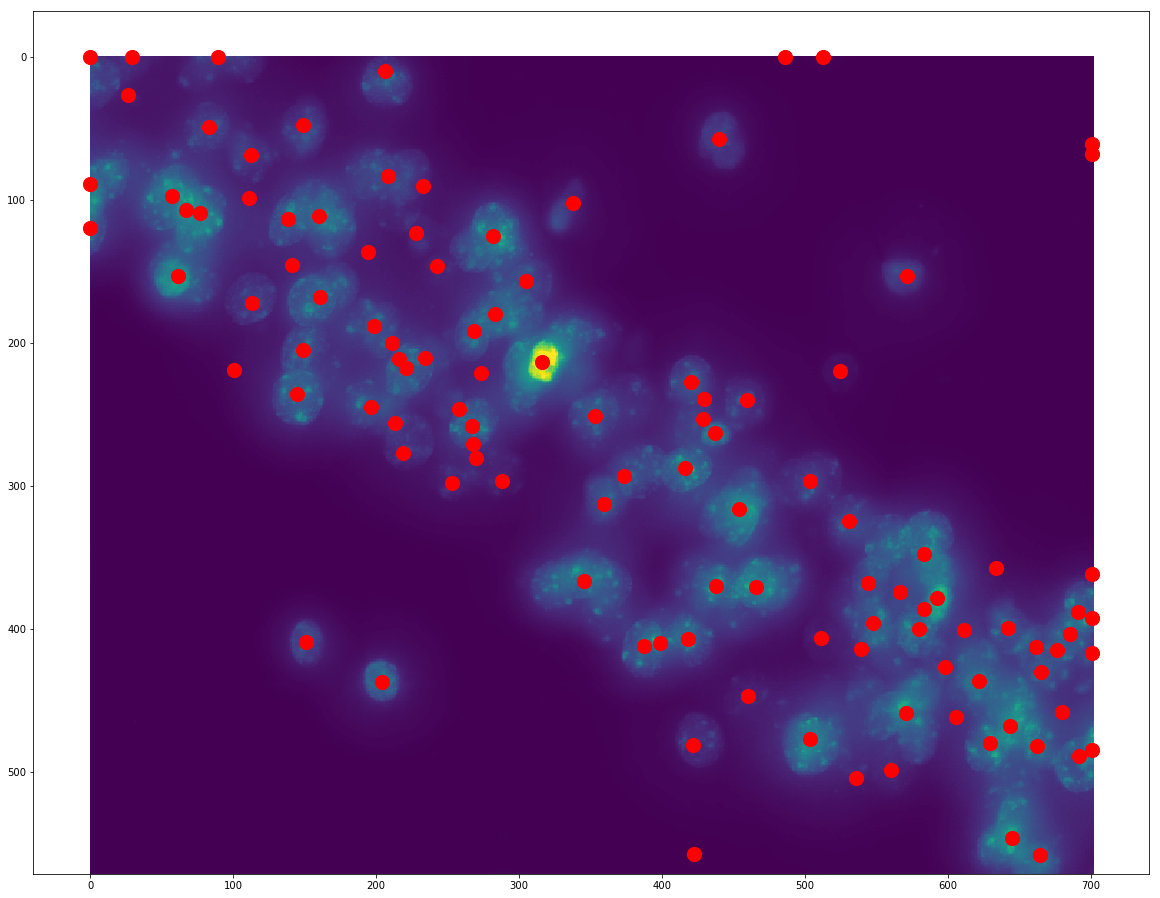

In [10]:
# Example/Test
img_raw = get_image()

img_gauss = gaussian_blur(img_raw, 5)
img_adeq = adapt_eq(img_gauss)

# 3 separate blob detections
log_cells = detect_blobs_3dlog(img_adeq, threshold = .007)
dog_cells = detect_blobs_3ddog(img_adeq, threshold = .05)
hess_cells = detect_blobs_3dhess(img_adeq, threshold = .009)

# place into one array
all_cells = np.concatenate((log_cells, dog_cells, hess_cells))

# cluster centroids
final_cells = cluster_centroids(all_cells[:,1], all_cells[:,0], all_cells[:,3], 150)

# Plotting
# Plot on top of max intensity projection
img_max = img_raw.max(axis=0)
f, ax = plt.subplots(1, figsize = (20,20))
plt.imshow(img_max)
plt.scatter(final_cells['x'], final_cells['y'], 200,  'r')

# uncomment if you wish to save the data frame to a csv.
# save_to_file(final_cells) 